In [57]:
import os
import pandas as pd
import collections
import pickle
#import cPickle
import _pickle as cPickle

import scipy
from scipy import sparse
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import nltk
import nltk.data
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize,sent_tokenize

import re
import string
import time
import codecs
from Bio import Medline

import gensim
from gensim import corpora, models, similarities
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec, CoherenceModel
from gensim.summarization import summarize

from collections import defaultdict

import pyLDAvis.gensim

import GapStatistics
import time

import bokeh

# Configurations and Variable Definitions

In [59]:
# Configuration: Data file name (it should be placed in the same ditrectory as the notebook file)
DATA_FILE = '/data/pubmed_result_6517_0900_"Pain"[Mesh]_Medline_EnglishOnlyFilter.txt'
#DATA_FILE = DATA_FILE = '/data/pubmedtext.txt'
#test variables
# test_pmid = '27179337'
test_pmid = '28324318'

In [60]:
# constant variables
CLEANED_ABSTRACT_COL = 'cleaned_abstract'
SUMMARY_ABSTRACT_COL = 'summary_abstract'
CLEANED_MINIMAL_ABSTRACT_COL = 'cleaned_minimal_abstract'
TOKENIZED_CLEAN_ABS_COL = 'tokenized_c_abstract'
TOKENIZED_RAW_ABS_COL = 'tokenized_r_abstract'
TOKEN_COUNT_RAW_ABS_COL = 'token_count_r_abstract'
TOKEN_COUNT_CLEAN_ABS_COL = 'token_count_c_abstract'
TOKEN_COUNT_Unq_CLEAN_ABS_COL = 'token_count_unq_c_abstract'

# Input File Processing

In [62]:
#Dictionary of medline terms: https://www.nlm.nih.gov/bsd/mms/medlineelements.html
#Note that this differs from above by removing grants and affiliations in an effort to minimize exceptions
def read_medline_data_raw(filename):
    recs = Medline.parse(open(filename, 'r'))
    text = pd.DataFrame(columns = ["pmid", "articletitle", "journaltitle", "abstract"])
    count = 0
    for rec in recs:
        try:
            pmid = rec['PMID']
            atitle = rec["TI"]
            jtitle = rec["JT"]
            pubdate = rec["DP"]
            abstr = rec["AB"]
            text = text.append(pd.DataFrame([[pmid,atitle, jtitle,pubdate, abstr]],
                columns=["pmid", "articletitle", "journaltitle", "pubdate", "abstract"]),ignore_index=True, verify_integrity=True)            
        except:
            pass
    text.set_index(text.pmid)
    return text

In [63]:
# get the Data file path

print("Cell started at: " + time.strftime("%c"))
try:
    approot = os.path.dirname(os.path.realpath('__file__'))
except NameError:  # if it is the main script, not a module
    import sys
    approot = os.path.dirname(os.path.abspath(sys.argv[0]))
DATA_PATH = approot + DATA_FILE

# Read in MEDLINE formatted text
%time papers = read_medline_data_raw(DATA_PATH)
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')
papers.to_csv('data/papers_pain_EngFilter_6_5_2017_raw_oct17update.csv')
print("Cell completed at: " + time.strftime("%c"))

Cell started at: Sun May 27 06:03:49 2018
CPU times: user 42min 3s, sys: 2min 18s, total: 44min 22s
Wall time: 44min 22s
Cell completed at: Sun May 27 06:48:20 2018


In [64]:
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update')

In [65]:
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202053 entries, 0 to 202052
Data columns (total 5 columns):
abstract        202053 non-null object
articletitle    202053 non-null object
journaltitle    202053 non-null object
pmid            202053 non-null object
pubdate         202053 non-null object
dtypes: object(5)
memory usage: 7.7+ MB


In [66]:
pubdatevalues = papers.pubdate.unique()
#pubdatevalues.tofile("pubdatevalues.csv", sep=',') Examine range of pubdates manually in csv

In [67]:
papers['pubdate_dtformat'] = pd.to_datetime(papers.pubdate, format='%Y', exact=False)
papers['pubyear'] = pd.DatetimeIndex(papers['pubdate_dtformat']).year
papers=papers.drop('pubdate_dtformat', axis=1)

In [68]:
papers.tail(10)

abstract  \
202043  AIMS: To conduct a systematic review to determ...   
202044  AIMS: To assess the influence of clenching sid...   
202045  AIMS: To determine if pressure pain thresholds...   
202046  AIMS: To evaluate the transient effects of ort...   
202047  AIMS: To analyze the methodologic quality, sum...   
202048  AIMS: To investigate the relationship between ...   
202049  AIMS: To evaluate whether a biobehavioral inte...   
202050  We propose that trigger-point dry needle (TrP-...   
202051  Erythrocytosis, or increased red blood cell ma...   
202052  PURPOSE: Juvenile idiopathic arthritis (JIA) i...   

                                             articletitle  \
202043  Systematic Review and Meta-analysis of the Eff...   
202044  Ipsilateral Molar Clenching Induces Less Pain ...   
202045  The Effects of Mandibular Advancement Device o...   
202046  Transient Pain Following Orthodontic Fixed App...   
202047  The Effectiveness of Physiotherapy in the Mana...   
202048  Circulating Omentin-1 and Chronic Painful Temp...   
202049  Temporomandibular Disorder Diagnostic Groups A...   
202050      Trigger-Point Dry Needling for the SOF Medic.   
202051  Secondary Hypertension, Erythrocytosis, and Un...   
202052  The Effects of Orthopedic Manual Physical Ther...   

                                             journaltitle      pmid  \
202043         Journal of oral & facial pain and headache  27472529   
202044         Journal of oral & facial pain and headache  27472527   
202045         Journal of oral & facial pain and headache  27472526   
202046         Journal of oral & facial pain and headache  27472525   
202047         Journal of oral & facial pain and headache  27472523   
202048         Journal of oral & facial pain and headache  27472522   
202049         Journal of oral & facial pain and headache  27472521   
202050  Journal of special operations medicine : a pee...  28088815   
202051  Journal of special operations medicine : a pee...  28088811   
202052  Pediatric physical therapy : the official publ...  27661250   

            pubdate  pubyear  
202043  Summer 2016     2016  
202044  Summer 2016     2016  
202045  Summer 2016     2016  
202046  Summer 2016     2016  
202047  Summer 2016     2016  
202048  Summer 2016     2016  
202049  Summer 2016     2016  
202050  Winter 2016     2016  
202051  Winter 2016     2016  
202052  Winter 2016     2016

In [70]:
papers.journaltitle.nunique()

5333

In [71]:
papers.to_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')
papers = pd.read_pickle('data/papers_pain_EngFilter_6_5_2017_raw_oct17update_Mar18year')

# Text Cleanup & Tokenization

## Remove "all-caps:" section headers, punctuation marks, numbers, and option for words in all capital letters

In [74]:
# This function will use regular expressions to remove all:
#  (1) words/phrases in all caps followed by :, (if filter_all_caps = True, eveything all-caps will be removed)     
#  (2) numbers
#  (3) one letter words (such as n or p or other mathematical symbols)
#  (4) punctuation marks
# return value is the list of all filtered words (except for numbers), and the clean abstracts

# A utility function for flattening the lists
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, str):
            for sub in flatten(el):
                yield sub
        else:
            yield el

# Filter text as described above            
def filterText(abstracts, filter_all_caps = False):    
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    if filter_all_caps:
        pattern = regex.pattern + r"|\b[A-Z]{2,}|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    else:
        pattern = regex.pattern + r"|(((\s|^)[A-Z]{2,}(,)*)*)(\s|^)(\b[A-Z]{2,}):|[0-9]+|\b\w\b|\d-\d|\W-\W|\s-\s" 
    
    #The list of all filtered words (except for numbers)
    # convert to a falttened set for faster results
    all_filtered_series = abstracts.apply(lambda d: re.findall(pattern, d))
    all_filtered = set(flatten(all_filtered_series.tolist()))
    non_digit_filtered = [y for y in all_filtered if not y.isdigit()]
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    
    return abstracts, non_digit_filtered

## Remove stop words

In [76]:
# This function will replace all the stop words, it also gets rid of the whitespaces
def removeWord(text, stop_list):
    new_text = []
    
    #first convert to a list
    text_list = str.split(text)
    
    #check for stop words
    for x in text_list:
        if x not in stop_list:
            new_text.append(x)
    
    #convert back to string
    new_text_str = ' '.join(new_text)
    
    return new_text_str

# This function will remove stop words using NLTK stop word list
# It will return processed abstracts and stop word list
def removeStopWords(abstracts):         
    # use NLTK's default stop word list
    stop_set = set(stopwords.words('english'))
    
    # find all stop words and remove them
    abstracts = abstracts.apply(lambda d: removeWord(d, stop_set))
    
    return abstracts, stop_set

## Convert to lower case, tokenize

In [78]:
# This fuction will convert everything to lower-case
def changeToLowerCase(abstracts):  
    abstracts = abstracts.apply(lambda d: d.lower())
    return abstracts

In [79]:
# This function will tokenize all sentences
def tokenizeAbstracts(abstracts):  
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = abstracts.apply(lambda d: tokenizer.tokenize(d))
    return tokens

## Combine Preprocess Functions

In [81]:
def preprocessAbstracts(abstracts):    
    # Remove all-caps words, numbers, 1-letter words, punctuation marks 
    abstracts, filtered = filterText(abstracts, filter_all_caps= False)
    
    # conevrt to lower-case
    abstracts = changeToLowerCase(abstracts)
    
    # Remove stop words
    abstracts, stop_list = removeStopWords(abstracts)
    filtered = filtered + list(stop_list)
    
    # tokenize
    tokens = tokenizeAbstracts(abstracts)
    
    return abstracts, tokens, filtered

In [82]:
# This can be helpful for word2vec models that need minimal preprocessing
def minimallyPreprocessAbstracts(abstracts):
    #define the regex pattern
    regex = re.compile('[%s]' % re.escape(re.sub('-', '', string.punctuation)))
    pattern = regex.pattern + r"|[0-9.]+" 
    
    #remove whatever needs to be filtered
    abstracts = abstracts.apply(lambda d: re.sub(pattern, '#NUM', d))
    abstracts = abstracts.apply(lambda d: re.sub('s-s', '', d))
    return abstracts

## Apply preprocessing

In [84]:
# preprocess the abstracts
papers[CLEANED_ABSTRACT_COL], papers[TOKENIZED_CLEAN_ABS_COL], filtered = preprocessAbstracts(papers.abstract)
papers[CLEANED_MINIMAL_ABSTRACT_COL] = minimallyPreprocessAbstracts(papers.abstract)
%time papers[TOKENIZED_RAW_ABS_COL] = tokenizeAbstracts(papers.abstract)
# pre-compute the token counts
papers[TOKEN_COUNT_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_RAW_ABS_COL] =papers[TOKENIZED_RAW_ABS_COL].map(lambda text: len(text))
papers[TOKEN_COUNT_Unq_CLEAN_ABS_COL] =papers[TOKENIZED_CLEAN_ABS_COL].map(lambda text: len(set(text)))

CPU times: user 13 s, sys: 1.14 s, total: 14.1 s
Wall time: 14.1 s


In [86]:
papers.to_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')
%time papers = pd.read_pickle('data/papapers_pain_EngFilter_6_5_2017_raw_preprocessed_oct17update_Mar18years')

CPU times: user 15.1 s, sys: 2.75 s, total: 17.8 s
Wall time: 17.8 s


In [88]:
#Test
print('Original Abstract: \n', papers.abstract[papers.pmid == test_pmid])
print('\nCleaned Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_ABSTRACT_COL])
print('\nTokenized Abstract: \n', papers.loc[papers.pmid == test_pmid, TOKENIZED_CLEAN_ABS_COL])
print('\nMinimally Processed Abstract: \n', papers.loc[papers.pmid == test_pmid, CLEANED_MINIMAL_ABSTRACT_COL])
papers[(papers.pmid == test_pmid)]

Original Abstract: 
 4    BACKGROUND: Despite their huge epidemiological...
Name: abstract, dtype: object

Cleaned Abstract: 
 4    despite huge epidemiological impact primary he...
Name: cleaned_abstract, dtype: object

Tokenized Abstract: 
 4    [despite, huge, epidemiological, impact, prima...
Name: tokenized_c_abstract, dtype: object

Minimally Processed Abstract: 
 4    BACKGROUND#NUM Despite their huge epidemiologi...
Name: cleaned_minimal_abstract, dtype: object


abstract  \
4  BACKGROUND: Despite their huge epidemiological...   

                                        articletitle  \
4  Botulinum neurotoxin type A for the treatment ...   

                       journaltitle      pmid   pubdate  pubyear  \
4  The journal of headache and pain  28324318  2017 Dec     2017   

                                    cleaned_abstract  \
4  despite huge epidemiological impact primary he...   

                                tokenized_c_abstract  \
4  [despite, huge, epidemiological, impact, prima...   

                            cleaned_minimal_abstract  \
4  BACKGROUND#NUM Despite their huge epidemiologi...   

                                tokenized_r_abstract  token_count_c_abstract  \
4  [BACKGROUND, Despite, their, huge, epidemiolog...                     113   

   token_count_r_abstract  token_count_unq_c_abstract  
4                     168                          85

# Topic Modeling with LDA

## Create Corpus, Dictionary, and Related Text Constructs

In [91]:
# create a dictionary mapping words to ids
abstract_list = papers[TOKENIZED_CLEAN_ABS_COL].values
ca_gs_dictionary = corpora.Dictionary(abstract_list)

#remove extremes (similar to tf-idf)
ca_gs_dictionary.filter_extremes(no_below=1, no_above=0.8)
ca_gs_dictionary.compactify()

In [92]:
#convert the dictionary to a bag of words
ca_gs_corpus = [ca_gs_dictionary.doc2bow(words) for words in abstract_list]
# corpora.mmcorpus.MmCorpus.serialize('data/ca_gensim.mm', corpus)
ca_gs_tfidf = models.TfidfModel(ca_gs_corpus)

## Topic Modeling via LDA

### Determine optimal number of topics through coherence testing

In [95]:
def LDA_compute_coherence_values(dictionary, corpus, texts, limit):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(2, limit, 6):
        model = models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5, 
                                                 workers=16)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [96]:
LDA_model_list, LDA_coherence_values = LDA_compute_coherence_values(dictionary=ca_gs_dictionary, corpus=ca_gs_corpus, texts=abstract_list, limit=50)

In [97]:
print(LDA_model_list)
print(LDA_coherence_values)

[<gensim.models.ldamulticore.LdaMulticore object at 0x7facb4f11630>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac74886390>, <gensim.models.ldamulticore.LdaMulticore object at 0x7facb64482e8>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac74e4bf28>, <gensim.models.ldamulticore.LdaMulticore object at 0x7facb4bdacc0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac757630f0>, <gensim.models.ldamulticore.LdaMulticore object at 0x7facb4e24278>, <gensim.models.ldamulticore.LdaMulticore object at 0x7fac75a90cc0>]
[0.3561077301764383, 0.48411174907153137, 0.49234757790822486, 0.4798594232379245, 0.46387423506553555, 0.49627455094681966, 0.5102653500537135, 0.4862196372850324]


In [98]:
with open('LDA_model_list.pkl', 'wb') as f:
    pickle.dump(LDA_model_list, f)
    
with open('LDA_coherence_values.pkl', 'wb') as f:
    pickle.dump(LDA_coherence_values, f)

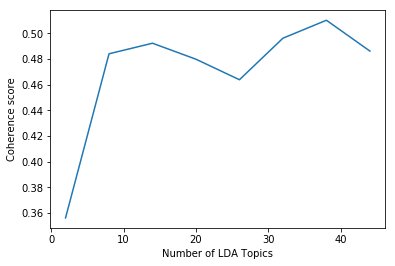

In [99]:
limit=50
x = range(2, limit, 6)
plt.plot(x, LDA_coherence_values)
plt.xlabel("Number of LDA Topics")
plt.ylabel("Coherence score")
# plt.legend(("LDA_coherence_values"), loc='best')
plt.show()

In [100]:
for m, cv in zip(x, LDA_coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3561
Num Topics = 8  has Coherence Value of 0.4841
Num Topics = 14  has Coherence Value of 0.4923
Num Topics = 20  has Coherence Value of 0.4799
Num Topics = 26  has Coherence Value of 0.4639
Num Topics = 32  has Coherence Value of 0.4963
Num Topics = 38  has Coherence Value of 0.5103
Num Topics = 44  has Coherence Value of 0.4862


In [101]:
num_of_LDA_topics = 25 #Derived from coherence testing of topic counts from 2 to 50 for LDA

### Run LDA with 25 topics

In [103]:
# %time lda = models.LdaModel(ca_gs_corpus, num_topics=num_of_LDA_topics, id2word =ca_gs_dictionary, update_every=5, passes=100)
%time lda_mc = models.ldamulticore.LdaMulticore(corpus=ca_gs_corpus, num_topics=num_of_LDA_topics, id2word=ca_gs_dictionary, passes=100, workers=16)

CPU times: user 33min 36s, sys: 2min 25s, total: 36min 2s
Wall time: 32min 48s


In [132]:
lda_mc.save('lda_mc')

## Doc-Topic distribution

In [117]:
# Get document topics
all_topics = lda_mc.get_document_topics(ca_gs_corpus, minimum_probability=0)
all_topics[100]

[(0, 0.00025477706),
 (1, 0.00025477706),
 (2, 0.00025477706),
 (3, 0.00025477706),
 (4, 0.00025477706),
 (5, 0.00025477706),
 (6, 0.00025477706),
 (7, 0.00025477706),
 (8, 0.00025477706),
 (9, 0.00025477706),
 (10, 0.00025477706),
 (11, 0.076396085),
 (12, 0.14749865),
 (13, 0.00025477706),
 (14, 0.00025477706),
 (15, 0.00025477706),
 (16, 0.00025477706),
 (17, 0.00025477706),
 (18, 0.00025477706),
 (19, 0.6194019),
 (20, 0.00025477706),
 (21, 0.08547166),
 (22, 0.066136174),
 (23, 0.00025477706),
 (24, 0.00025477706)]

In [119]:
print(len(doc_topics))

25


## Prepare the Input files for Tensorboard

In [107]:
import gensim
import pandas as pd
import smart_open
import random
from smart_open import smart_open

In [120]:
# create file for tensors
with smart_open('doc_lda_tensor.tsv','w') as w:
    for doc_topics in all_topics:
        for topics in doc_topics:
            w.write(str(topics[1])+ "\t")
        w.write("\n")
        
# create file for metadata
with smart_open('doc_lda_metadata.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j, k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (j, k))

In [121]:
tensors = []
for doc_topics in all_topics:
    doc_tensor = []
    for topic in doc_topics:
        if round(topic[1], 3) > 0:
            doc_tensor.append((topic[0], float(round(topic[1], 3))))
    # sort topics according to highest probabilities
    doc_tensor = sorted(doc_tensor, key=lambda x: x[1], reverse=True)
    # store vectors to add in metadata file
    tensors.append(doc_tensor[:5])

# overwrite metadata file
i=0
with smart_open('doc_lda_metadata2.tsv','w') as w:
    w.write('articletitle\tjournaltitle\n')
    for j,k in zip(papers.articletitle, papers.journaltitle):
        w.write("%s\t%s\n" % (''.join((str(j), str(tensors[i]))),k))
        i+=1

### we upload the previous tensor file "doc_lda_tensor.tsv" and this new metadata file to http://projector.tensorflow.org/ . 

### To visualize using T-SNE [ Just change the tab in left ]

In [143]:
lda_mc.show_topic(topicid=0, topn=25)

[('pain', 0.030949552),
 ('stimulation', 0.019985871),
 ('stimuli', 0.009265644),
 ('sensory', 0.00837415),
 ('responses', 0.007198256),
 ('threshold', 0.0069853147),
 ('noxious', 0.006040672),
 ('nerve', 0.0059847333),
 ('response', 0.0059348578),
 ('electrical', 0.005842353),
 ('nociceptive', 0.0057952637),
 ('evoked', 0.0057408167),
 ('painful', 0.005429999),
 ('stimulus', 0.005425263),
 ('thresholds', 0.0053729643),
 ('brain', 0.0053180885),
 ('heat', 0.00522469),
 ('cold', 0.005055869),
 ('central', 0.0048260055),
 ('skin', 0.0046770433),
 ('changes', 0.0042510466),
 ('activity', 0.004143791),
 ('neurons', 0.0040222956),
 ('cortex', 0.0040217717),
 ('spinal', 0.003837736)]

In [124]:
import pyLDAvis.gensim

viz = pyLDAvis.gensim.prepare(lda_mc, ca_gs_corpus, ca_gs_dictionary)
pyLDAvis.display(viz)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


## Topic Networks

In [134]:
# get topic distributions
topic_dist = lda_mc.state.get_lambda()

# get topic terms
num_words = 50
topic_terms = [{w for (w, _) in lda_mc.show_topic(topic, topn=num_words)} for topic in range(topic_dist.shape[0])]

In [135]:
from scipy.spatial.distance import pdist, squareform
from gensim.matutils import jensen_shannon
import networkx as nx
import itertools as itt

# calculate distance matrix using the input distance metric
def distance(X, dist_metric):
    return squareform(pdist(X, lambda u, v: dist_metric(u, v)))

topic_distance = distance(topic_dist, jensen_shannon)

# store edges b/w every topic pair along with their distance
edges = [(i, j, {'weight': topic_distance[i, j]})
         for i, j in itt.combinations(range(topic_dist.shape[0]), 2)]

# keep edges with distance below the threshold value
k = np.percentile(np.array([e[2]['weight'] for e in edges]), 20)
edges = [e for e in edges if e[2]['weight'] < k]

In [138]:
import  plotly.offline as py
from plotly.graph_objs import *
import plotly.figure_factory as ff

py.init_notebook_mode()

# add nodes and edges to graph layout
G = nx.Graph()
G.add_nodes_from(range(topic_dist.shape[0]))
G.add_edges_from(edges)

graph_pos = nx.spring_layout(G)

In [139]:
# initialize traces for drawing nodes and edges 
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            xanchor='left'
        ),
        line=dict(width=2)))

edge_trace = Scatter(
    x=[],
    y=[],
    text=[],
    line=Line(width=0.5, color='#888'),
    hoverinfo='text',
    mode='lines')


# no. of terms to display in annotation
n_ann_terms = 10

# add edge trace with annotations
for edge in G.edges():
    x0, y0 = graph_pos[edge[0]]
    x1, y1 = graph_pos[edge[1]]
    
    pos_tokens = topic_terms[edge[0]] & topic_terms[edge[1]]
    neg_tokens = topic_terms[edge[0]].symmetric_difference(topic_terms[edge[1]])
    pos_tokens = list(pos_tokens)[:min(len(pos_tokens), n_ann_terms)]
    neg_tokens = list(neg_tokens)[:min(len(neg_tokens), n_ann_terms)]
    annotation = "<br>".join((": ".join(("+++", str(pos_tokens))), ": ".join(("---", str(neg_tokens)))))
    
    x_trace = list(np.linspace(x0, x1, 10))
    y_trace = list(np.linspace(y0, y1, 10))
    text_annotation = [annotation] * 10
    x_trace.append(None)
    y_trace.append(None)
    text_annotation.append(None)
    
    edge_trace['x'] += x_trace
    edge_trace['y'] += y_trace
    edge_trace['text'] += text_annotation

# add node trace with annotations
for node in G.nodes():
    x, y = graph_pos[node]
    node_trace['x'].append(x)
    node_trace['y'].append(y)
    node_info = ''.join((str(node+1), ': ', str(list(topic_terms[node])[:n_ann_terms])))
    node_trace['text'].append(node_info)
    
# color node according to no. of connections
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color'].append(len(adjacencies))

In [140]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(showlegend=False,
                hovermode='closest',
                xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=True),
                yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=True)))

py.iplot(fig)